# Final Project for INFO 6350
### Project Team: Yun Zhou (yz2685)

# Part 0: Background

**Statement of the problem:** The annual financial reports (10K reports) of the publicly traded companies are usually very lengthy and extensive, few people had the time and energy to read such report across all the companies over the years, and make accurate predications on the companies' financial performances based on the hundreds of reports every year of which the average page number can be up to 100 pages or 30k - 60k words. 

**Impact:** The results from my analysis will deliver meaningful recommendations to not only the NLP scholars, but also to the real-world managers,  executives, and investors. By using text mining techniques, we can greatly improve the efficiency of the decision-making process in the business world, saving executives/managers' time reading their competitors' verbose 10K reports. Additionally, the project result will help the individual investors save time analyzing the 10K reports and make better investment decisions in the stock market.   

# Part 1: Research Questions

### Q1: What are the tones or sentiments used to describe the risks of companies? Are they related to the stock prices? 

### Q2: What are the most important features in the **risk sections** in the 10-k reports that can make predictions or classifications on the companies' stock prices?

### Q3: Given a risk section, can our classifier correctly determine if the record is before-2014 or post-2014?  

# Part 2: Methodologies

**Methodology:** 
* Perform web crawling tasks to collect the financial reports over the years of the companies of interest. 
* Make gold labels based on the companies' financial metrics, such as earnings per share or net profit margin ratio. and label each report as below-average-margin vs. above-average-margin
* Clean the corpus, remove tables, figures, stopwords, etc. 
* Perform sentiment analysis on the corpus to detect the positiveness and/or negativeness of the financial situations of the companies over the years. 
* Build regression models to predict the companies' financial performance and calculate R^2
* Build various classifiers (e.g. random forest, decision tree, SVD, logistic classification, BERT) to classify the companies into below-average and above-average based on the financial metrics. Calculate the F1 and accuracy scores 
* Compare the results from regression models and classifers.
* Make recommendations on how to choose the best stuitable model for such tasks in the future. 

# Part 3: Code

In [150]:
# import libraries
import requests
import urllib
from bs4 import BeautifulSoup
import simplejson as json
from urllib.request import Request, urlopen
from fake_useragent import UserAgent
from selenium import webdriver
import time
import re
import pandas as pd
import json
import datetime
import numpy as np
import unicodedata
from collections import Counter
from nltk import word_tokenize
import matplotlib.pyplot as plt
import pickle
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_selection import SelectKBest, mutual_info_classif
from   sklearn.linear_model import LogisticRegression, LinearRegression
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import StandardScaler
import spacy

In [2]:
# define the base url needed to create the file url.
base_url = r"https://www.sec.gov"
header = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36'
}

# four-digit year pattern
yearPattern = re.compile(r'\d{4}$')

In [3]:
list_cik = pd.read_csv('nasdaq100_ticker_cik_mapping.csv').fillna(value = 0).head(50)
len(list_cik)

50

In [4]:
list_cik.head()

,symbol,company,cik,market_cap_05132022,last_sale_05132022
0,AAPL,Apple Inc. Common Stock,320193,"2,550,149,340,600",$147.09
1,MSFT,Microsoft Corporation Common Stock,789019,"1,954,720,100,164",$261.36
2,GOOG,Alphabet Inc. Class C Capital Stock,1652044,"1,542,091,474,456","$2,341.83"
3,GOOGL,Alphabet Inc. Class A Common Stock,1652044,"1,538,927,382,547","$2,337.02"
4,AMZN,"Amazon.com, Inc. Common Stock",1018724,"1,137,905,971,901","$2,236.80"


## I: Web Scraping

## 1. Scraping the SEC Query Page

In [5]:
# define lists to store the data scraped from the SEC website
ciks = []
risks = []
years = []
urls = []
companies = []
symbols = []

# base URL for the SEC EDGAR browser
endpoint = r"https://www.sec.gov/cgi-bin/browse-edgar"

In [6]:
driver = webdriver.Firefox()

### 1a. Helper functions 

In [7]:
# get the links to the 10k reports 
def get10kPages(url):
    response = requests.get(url = url, headers=header)
    soup10k = BeautifulSoup(response.content, 'html.parser')
    # print(response)
    # print(response.url)
    return response.url

In [8]:
def get10kLinks(url, list_of_10ks):
    response = requests.get(url = url, headers=header)
    soup = BeautifulSoup(response.content, 'html.parser')
    # for a in soup.find_all('a', href=True):
        # url = a['href']
        # print(url)
        
    suffix = "htm";

    tables = soup.find('table')
    rows = tables.find_all('tr')
    if len(rows) > 0:
        row10k = rows[1] # row 1 has link to 10k report
        # print(row10k)
        for a in row10k.find_all('a', href=True):
            url = a['href']
            if url.endswith(suffix):
                list_of_10ks.append("https://www.sec.gov"+ url)
                # print("https://www.sec.gov"+ url)

In [9]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

In [10]:
# create a function that will scrap the 10k report 
def scrap10k(url, cik, company, symbol):
    driver.get(url)

    time.sleep(2) # give browser some time to load the js 

    html = driver.page_source
    sp = BeautifulSoup(html)
    
    text = ""
    for d in sp.find_all(text=True):
        text += d.get_text()
    
    # cleaning 
    # print(text)
    text = text.replace(u'\xa0', u' ').lower()
                
    # extract risk factor sections only
    # print(url)
    
    # get fiscal year     
    yr = ""
    for span in sp.find_all(text=True):
        stext = span.text
        if (stext.find("January") != -1
         or stext.find("February") != -1
         or stext.find("March") != -1
         or stext.find("April") != -1
         or stext.find("May") != -1
         or stext.find("June") != -1
         or stext.find("July") != -1
         or stext.find("August") != -1
         or stext.find("September") != -1
         or stext.find("October") != -1
         or stext.find("November") != -1
         or stext.find("December") != -1):
            stext = stext.strip()
            yr = stext[-4:]
            # print(yr)
            break
            
    
    # print("=================")    
    # print(text)
    
    # proceed only when a valid year is scraped 
    yr_match = re.match(yearPattern, yr)
    if yr_match != None:
        yr = int(yr) # convert string to int
        if yr > 2006:
            start = find_nth(text, "item 1a.", 2)
            # print("start index", start)
            end = find_nth(text, "item 1b.", 2)
            # print("end index", end)
            substring = text[start:end]
            if len(substring) > 100: # only pull longer risk factors 
                risks.append(substring)
                years.append(yr)
                ciks.append(cik)
                urls.append(url)
                companies.append(company)
                symbols.append(symbol)
    #     else:
    #         print("year before 2007: ", yr)
    # else:
    #     print("fiscal year not detected")

In [11]:
def getDataByCIK(cik, company, symbol):
    ########################################
    ### Step 1. Scraping the SEC Query Page
    ########################################
    # define our parameters dictionary
    param_dict = {'action':'getcompany',
                  'CIK': cik,
                  'type':'10-k',
                  'dateb':'20230101',
                  'owner':'exclude',
                  'start':'',
                  'output':'',
                  'count':'100'}

    # request the url, and then parse the response.
    response = requests.get(url = endpoint, params = param_dict, headers=header)
    # response = requests.get(url = endpoint, params = param_dict)
    soup = BeautifulSoup(response.content, 'html.parser')

    # print('Request Successful')
    # print(response.url)
    
    doc_table = soup.find_all(class_ = "blueRow")
    
    data = soup.find_all(class_='blueRow')

    list_10k = []

    for i, row in enumerate(data): 
        for a in data[i].find_all('a', href=True):
            url = a['href']
            if (url.startswith('/Archives/edgar/')):
                list_10k.append("https://www.sec.gov"+ url)
                # print("https://www.sec.gov"+ url)
                
    ########################################
    ### Step 2. Scraping Company Page 
    ########################################
    
    list_of_links = []
    for link in list_10k:
        list_of_links.append(get10kPages(link))
        
    # get the url for 10k report 
    list_of_10ks = []
    for url in list_of_links:
        get10kLinks(url, list_of_10ks)
        

    ########################################
    ### Step 3. Scraping 10k Reports 
    ########################################
    for report in list_of_10ks:
        scrap10k(report, cik, company, symbol)

In [12]:
# test
# scrap10k('https://www.sec.gov/Archives/edgar/data/1018724/000101872419000004/amzn-20181231x10k.htm', "1018724", "amzn")

In [13]:
# test
# getDataByCIK("1067983", "brk-b")

### 1b. Run scripts for all the companies of interest

In [14]:
%%time
for i, row in list_cik.iterrows():
    getDataByCIK(row.cik, row.company, row.symbol)

CPU times: user 8min 15s, sys: 15.4 s, total: 8min 31s
Wall time: 30min 56s


### 1c. Create Data Frame

In [15]:
# create a data frame
data_tuples = list(zip(ciks, symbols, companies, years, risks, urls))
# data_tuples

df = pd.DataFrame(data_tuples, columns=['cik', 'symbol', 'company', 'fiscal_year', 'risk', 'url'])

In [16]:
df.head()

,cik,symbol,company,fiscal_year,risk,url
0,320193,AAPL,Apple Inc. Common Stock,2018,item 1a.risk factorsthe following discussion o...,https://www.sec.gov/Archives/edgar/data/320193...
1,320193,AAPL,Apple Inc. Common Stock,2016,item 1a. risk factorsthe following discussion ...,https://www.sec.gov/Archives/edgar/data/320193...
2,320193,AAPL,Apple Inc. Common Stock,2014,item 1a.\nrisk factors the following discussi...,https://www.sec.gov/Archives/edgar/data/320193...
3,789019,MSFT,Microsoft Corporation Common Stock,2018,item 1a. risk factors \nour operations and fin...,https://www.sec.gov/Archives/edgar/data/789019...
4,789019,MSFT,Microsoft Corporation Common Stock,2016,item 1a. risk factors our operations and fina...,https://www.sec.gov/Archives/edgar/data/789019...


In [17]:
len(df)

170

## II. Scrap stock prices from Yahoo Finance 

In [74]:
dict = {}

In [77]:
def getStockPricesByTicker(ticker, fiscal_year, period1, period2):
    url_history = f'https://finance.yahoo.com/quote/{ticker}/history?period1={period1}&period2={period2}&interval=1mo&filter=history&frequency=1mo&includeAdjustedClose=false'
    
    respf = requests.get(url_history, headers=header)
    # print(respf)
    
    soupf = BeautifulSoup(respf.text, 'html.parser')
    
    patternf = re.compile(r'\s--\sData\s--\s')
    script_data = soupf.find('script', text=patternf).contents[0]
    
    start = script_data.find("context")-2
    json_data = json.loads(script_data[start:-12])
    
    # get historical stock prices 
    HistoricalPriceStore = json_data['context']['dispatcher']['stores']['HistoricalPriceStore']
    # print(HistoricalPriceStore)
    
    # clean the stock price data 
    close = -99999 #default
    for row in HistoricalPriceStore['prices']:
        date = row['date']
        dt_formatted = datetime.datetime.fromtimestamp(date).date() # using the local timezone

        # get the stock price in December of a given year 
        if dt_formatted.month == 12 and dt_formatted.year == fiscal_year and 'close' in row:
            # debug
            # print(ticker, "=========", fiscal_year, "=====", row['date'])
            # print(HistoricalPriceStore)
            close = row['close']
            break # once find a December record then stop looking

    if dict.get(ticker) == None:
        dict[ticker] = {}
        
    dict[ticker][fiscal_year] = close

### 2b. Run scripts for all the records collected from #1

In [65]:
# %%time

# # test
# for i, row in df.iterrows():
#     if row.symbol == 'AVGO':
#         ticker = row.symbol
#         fiscal_year = row.fiscal_year
#         # period1 = '1167609600' # 2007-01-01
#         # period2 = '1672444800' # 2022-12-30
#         getStockPricesByTicker('AVGO', fiscal_year, '1167609600', '1672444800')

In [45]:
# df[df['symbol'] == 'AVGO']

,cik,symbol,company,fiscal_year,risk,url
31,1730168,AVGO,Broadcom Inc. Common Stock,2018,"item 1a. risk factorsas noted above, broadcom ...",https://www.sec.gov/Archives/edgar/data/173016...


In [78]:
%%time
for i, row in df.iterrows():
    ticker = row.symbol
    fiscal_year = row.fiscal_year
    # period1 = '1167609600' # 2007-01-01
    # period2 = '1672444800' # 2022-12-30
    getStockPricesByTicker(ticker, fiscal_year, '1167609600', '1672444800')

CPU times: user 23.6 s, sys: 1.3 s, total: 24.9 s
Wall time: 5min 57s


### 2c. Create data frames for stock prices

In [81]:
len(dict)

35

In [84]:
df_fi = pd.DataFrame.from_records(
    [
        (level1, level2, leaf)
        for level1, level2_dict in dict.items()
        for level2, leaf in level2_dict.items()
    ],
    columns=['symbol', 'fiscal_year', 'price']
)

In [85]:
df_fi.head()

,symbol,fiscal_year,price
0,AAPL,2018,39.435001
1,AAPL,2016,28.955000
2,AAPL,2014,27.594999
3,MSFT,2018,101.570000
4,MSFT,2016,62.139999


### 2d. Merge two data frames

In [140]:
merged_df = pd.merge(df, df_fi, how='left', on=['fiscal_year','symbol'])

In [141]:
merged_df

,cik,symbol,company,fiscal_year,risk,url,price
0,320193,AAPL,Apple Inc. Common Stock,2018,item 1a.risk factorsthe following discussion o...,https://www.sec.gov/Archives/edgar/data/320193...,39.435001
1,320193,AAPL,Apple Inc. Common Stock,2016,item 1a. risk factorsthe following discussion ...,https://www.sec.gov/Archives/edgar/data/320193...,28.955000
2,320193,AAPL,Apple Inc. Common Stock,2014,item 1a.\nrisk factors the following discussi...,https://www.sec.gov/Archives/edgar/data/320193...,27.594999
3,789019,MSFT,Microsoft Corporation Common Stock,2018,item 1a. risk factors \nour operations and fin...,https://www.sec.gov/Archives/edgar/data/789019...,101.570000
4,789019,MSFT,Microsoft Corporation Common Stock,2016,item 1a. risk factors our operations and fina...,https://www.sec.gov/Archives/edgar/data/789019...,62.139999
...,...,...,...,...,...,...,...
165,1048286,MAR,Marriott International Class A Common Stock,2011,item 1a.risk factors.forward-looking statement...,https://www.sec.gov/Archives/edgar/data/104828...,29.170000
166,1048286,MAR,Marriott International Class A Common Stock,2010,item 1a.\nrisk factors. forward-looking\nstat...,https://www.sec.gov/Archives/edgar/data/104828...,39.151745
167,1048286,MAR,Marriott International Class A Common Stock,2007,item 1a.\nrisk factors. forward-looking state...,https://www.sec.gov/Archives/edgar/data/104828...,31.863121
168,1637459,KHC,The Kraft Heinz Company Common Stock,2018,item 1a. risk factors.industry riskswe operat...,https://www.sec.gov/Archives/edgar/data/163745...,43.040001


## III: Exploratory Analysis & Data Cleaning

### 0. Helper functions

In [132]:
def word_count(text):
    counter = Counter()
    tokens_nltk = word_tokenize(text)

    for token in tokens_nltk:
        counter[token] += 1
    return sum(counter.values())

### 1. Exclude invalid stock prices 

In [142]:
merged_df = merged_df[merged_df['price'] >= 0]

### 2. Clean the text

In [143]:
text_list = []
text_len = []
for text in merged_df['risk']:
    text = unicodedata.normalize('NFKD', text.replace("\'", "'").replace("\ in\ form", " inform").replace("\n", " ").lower().strip())
    text_list.append(text)
    cnt = word_count(text)
    text_len.append(cnt)

### 3. Add more metadata

In [144]:
# add the cleaned text as a column to the df
merged_df['text'] = text_list

/var/folders/hb/cp1k8j5x3dj82qvtzxhwyn280000gn/T/ipykernel_47703/237560845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['text'] = text_list


In [145]:
merged_df['word_count'] = text_len

/var/folders/hb/cp1k8j5x3dj82qvtzxhwyn280000gn/T/ipykernel_47703/945730304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['word_count'] = text_len


In [146]:
merged_df.describe()

,cik,fiscal_year,price,word_count
count,1.690000e+02,169.000000,169.000000,169.000000
mean,7.951891e+05,2013.224852,122.958714,22485.692308
std,4.226564e+05,3.497836,257.316189,19288.844671
min,2.488000e+03,2007.000000,2.160000,1797.000000
25%,7.075490e+05,2010.000000,25.260000,8777.000000
50%,8.043280e+05,2014.000000,48.001999,14185.000000
75%,1.065280e+06,2016.000000,102.949997,30629.000000
max,1.730168e+06,2020.000000,1722.420044,75761.000000


In [147]:
merged_df.head()

,cik,symbol,company,fiscal_year,risk,url,price,text,word_count
0,320193,AAPL,Apple Inc. Common Stock,2018,item 1a.risk factorsthe following discussion o...,https://www.sec.gov/Archives/edgar/data/320193...,39.435001,item 1a.risk factorsthe following discussion o...,8955
1,320193,AAPL,Apple Inc. Common Stock,2016,item 1a. risk factorsthe following discussion ...,https://www.sec.gov/Archives/edgar/data/320193...,28.955000,item 1a. risk factorsthe following discussion ...,8575
2,320193,AAPL,Apple Inc. Common Stock,2014,item 1a.\nrisk factors the following discussi...,https://www.sec.gov/Archives/edgar/data/320193...,27.594999,item 1a. risk factors the following discussio...,8825
3,789019,MSFT,Microsoft Corporation Common Stock,2018,item 1a. risk factors \nour operations and fin...,https://www.sec.gov/Archives/edgar/data/789019...,101.570000,item 1a. risk factors our operations and fina...,9600
4,789019,MSFT,Microsoft Corporation Common Stock,2016,item 1a. risk factors our operations and fina...,https://www.sec.gov/Archives/edgar/data/789019...,62.139999,item 1a. risk factors our operations and fina...,7477


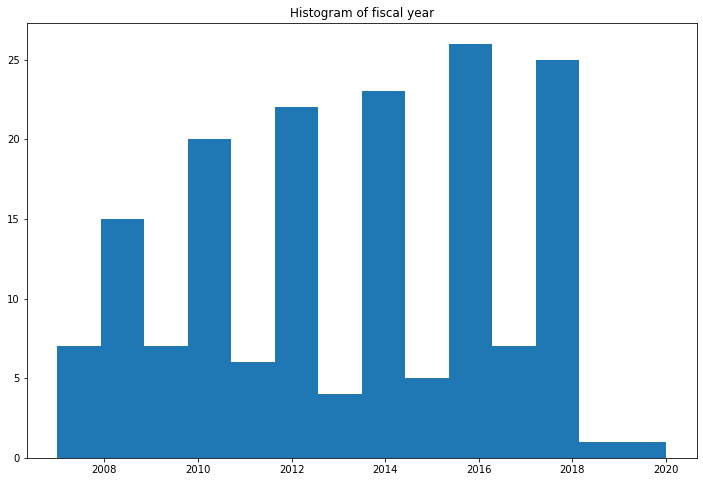

In [153]:
plt.subplots(figsize=(12,8))
plt.hist(merged_df.fiscal_year, bins=merged_df.fiscal_year.nunique())
plt.title("Histogram of fiscal year")
plt.show()

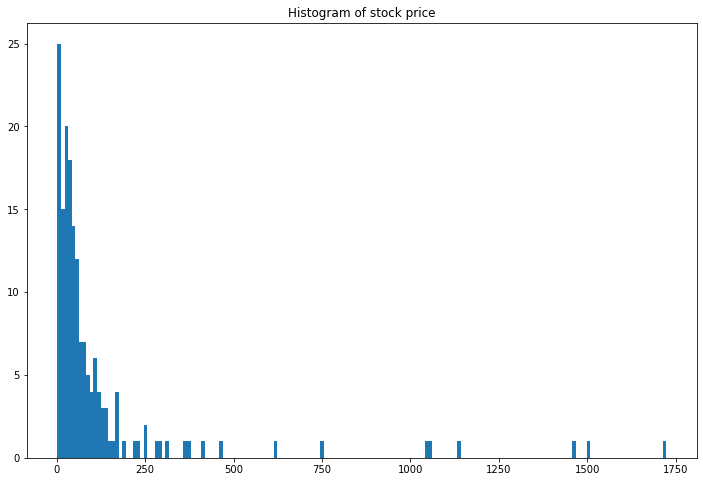

In [154]:
plt.subplots(figsize=(12,8))
plt.hist(merged_df.price, bins=merged_df.price.nunique())
plt.title("Histogram of stock price")
plt.show()

#### It seemed most of the stock prices fall into <= USD 250 bucket. 

#### Next, I removed the duplicates in the data frame based on cik and fiscal_year, and removed outliers with stock prices greater than USD 250. 

In [159]:
data = merged_df.drop_duplicates(subset=['cik', 'fiscal_year'])

In [175]:
data = data[data.price <= 250]

In [176]:
len(data)

152

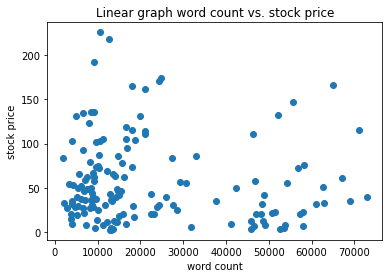

In [177]:
# depicting the visualization after dropping duplicates and outliners 
plt.scatter(data.word_count, data.price) 
plt.xlabel('word count') 
plt.ylabel('stock price') 
plt.title("Linear graph word count vs. stock price")
plt.show() 

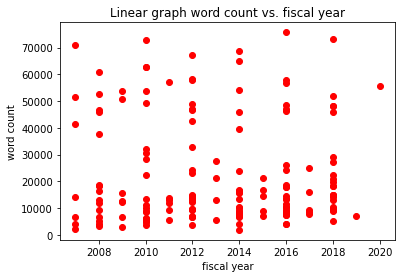

In [172]:
# depicting the visualization
plt.scatter(data.fiscal_year, data.word_count, color="red") 
plt.xlabel('fiscal year') 
plt.ylabel('word count') 
plt.title("Linear graph word count vs. fiscal year")
plt.show() 

#### From the graph above, we couldn't find obvious trend of either decreasing or increasing word count as time goes by. 

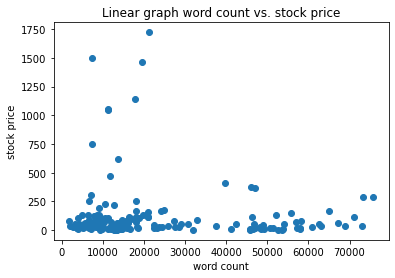

In [174]:
# depicting the visualization
plt.scatter(merged_df.word_count, merged_df.price) 
plt.xlabel('word count') 
plt.ylabel('stock price') 
plt.title("Linear graph word count vs. stock price")
plt.show() 

#### From the graph above, we couldn't find any obvious correlation between word count and stock prices. 

#### I pulled the companies with stock prices above USD 750 for sanity check. It seemed they were accurate. 

In [158]:
merged_df[merged_df.price > 750]

,cik,symbol,company,fiscal_year,risk,url,price,text,word_count
8,1652044,GOOG,Alphabet Inc. Class C Capital Stock,2017,item 1a.risk factorsour operations and financi...,https://www.sec.gov/Archives/edgar/data/165204...,1046.400024,item 1a.risk factorsour operations and financi...,11405
9,1652044,GOOGL,Alphabet Inc. Class A Common Stock,2017,item 1a.risk factorsour operations and financi...,https://www.sec.gov/Archives/edgar/data/165204...,1053.400024,item 1a.risk factorsour operations and financi...,11405
10,1018724,AMZN,"Amazon.com, Inc. Common Stock",2018,item 1a.risk factorsplease carefully consider ...,https://www.sec.gov/Archives/edgar/data/101872...,1501.969971,item 1a.risk factorsplease carefully consider ...,7367
97,1075531,BKNG,Booking Holdings Inc. Common Stock,2018,item 1a. risk factors the following risk fact...,https://www.sec.gov/Archives/edgar/data/107553...,1722.420044,item 1a. risk factors the following risk fact...,21340
98,1075531,BKNG,Booking Holdings Inc. Common Stock,2016,item 1a. risk factors the following risk fact...,https://www.sec.gov/Archives/edgar/data/107553...,1466.060059,item 1a. risk factors the following risk fact...,19489
99,1075531,BKNG,Booking Holdings Inc. Common Stock,2014,item 1a. risk factors the following risk fac...,https://www.sec.gov/Archives/edgar/data/107553...,1140.209961,item 1a. risk factors the following risk fac...,17825


## IV: Text Analysis

## 0. Helper Functions

## 1. Sentiment Analysis 

## 2. Classification

In [ ]:
# import unicodedata

# text = unicodedata.normalize('NFKD', text.replace("\'", "'").replace("\ in\ form", " inform").replace("\n", " ").lower().strip())

In [ ]:
# print(text)
# dev_docs = [doc for doc in text.split('\n')] 

In [ ]:
# from   sklearn.feature_extraction.text import TfidfVectorizer
# from   nltk.corpus import stopwords
# import string

# # Making stopwords list
# stoplist = stopwords.words('english')
# for el in [i for i in string.punctuation]:
#     stoplist.append(el)

# # Set up vectorizer
# vectorizer = TfidfVectorizer(
#     encoding='utf-8',
#     min_df=1, # include words that occur in as few as a single document, 1 = a single document
#     max_df=1.0, # include words that occur in as many as all documents, 1.0 = 100% = all documents
#      binary=False,
#     norm='l2',
#     stop_words = stoplist,
#     use_idf=True
# )

# X = vectorizer.fit_transform(dev_docs)

In [ ]:
# print(X.shape)

In [ ]:
# print(X)

# Part 4: Analysis

# References

* https://stackoverflow.com/questions/48687857/python-json-list-to-pandas-dataframe

* https://www.youtube.com/watch?v=fw4gK-leExw&ab_channel=IzzyAnalytics